In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats

In [147]:
df = pd.read_csv("../toydata/titanic.csv")
print(f"{df.shape}")
print(df.iloc[0,:].to_string())

(891, 15)
survived                 0
pclass                   3
sex                   male
age                   22.0
sibsp                    1
parch                    0
fare                  7.25
embarked                 S
class                Third
who                    man
adult_male            True
deck                   NaN
embark_town    Southampton
alive                   no
alone                False


In [142]:
def calculate_signal(
    df,
    col,
    target_col,
    seg_col=None,
    exposure_col=None,
    exposure_on_target_too=True,
):

    df = df.copy()

    # placeholder col for segment column
    if seg_col is None:
        seg_col = "_seg"
        if seg_col in df.columns:
            raise ValueError(f"Column '{seg_col}' is reserved, change column name.")
        df[seg_col] = "all"

    # aggregate
    agg_dict = {}
    agg_dict["count"] = (target_col, np.size)
    agg_dict[target_col] = (target_col, "sum")
    if exposure_col is not None:
        agg_dict[exposure_col] = (exposure_col, "sum")

        if exposure_on_target_too:
            tar_exp = f"{target_col}_{exposure_col}"
            df[tar_exp] = df[target_col].mul(df[exposure_col])
            agg_dict[tar_exp] = (tar_exp, "sum")

    _ = df.groupby([seg_col, col], dropna=False, observed=False)
    _ = _.agg(**agg_dict)

    # count dist
    grps = _.groupby(seg_col, dropna=False, observed=False)
    for name, group in grps:
        group["count_dist"] = group["count"].div(group["count"].sum())
        _.loc[group.index,["count_dist"]] = group[["count_dist"]]

    # rates
    grps = _.groupby(seg_col, dropna=False, observed=False)
    for name, group in grps:
        group[f"{target_col}_dist"] = group[target_col].div(group[target_col].sum())
        group[f"{target_col}_rate"] = group[target_col].div(group["count"])
        _.loc[group.index,[f"{target_col}_dist", f"{target_col}_rate"]] = group[[f"{target_col}_dist", f"{target_col}_rate"]]

    # exp rates
    if exposure_col is not None:
        grps = _.groupby(seg_col, dropna=False, observed=False)
        for name, group in grps:
            group[f"{tar_exp}_dist"] = group[tar_exp].div(group[tar_exp].sum())
            group[f"{tar_exp}_rate"] = group[tar_exp].div(group[exposure_col])

            _.loc[group.index,[f"{tar_exp}_dist", f"{tar_exp}_rate"]] = group[[f"{tar_exp}_dist", f"{tar_exp}_rate"]]

    if seg_col == "_seg":
        _.index = _.index.droplevel(0)

    return _

In [143]:
def plot_bar_and_line(
    df, col, target_col, rotation=0, y_lim=(None,), y_lim2=(None,), ax2_y_lim=(None,), figsize = (15, 5),
):

    df2 = df.copy()

    # add dummy index for single level
    if df2.index.nlevels == 1:
        df2.index = pd.MultiIndex.from_product([["all"], df2.index], names=["all", df2.index.name])
    elif len(df2.index.levels) > 2:
        raise ValueError(f"index levels in input can only be 1 or 2, {df2.index.levels = }")

    # plot for each segment
    segs = df2.index.levels[0]

    for seg in segs:

        df3 = df2.loc[seg,:]

        fig, ax = plt.subplots(1, 2, figsize=figsize)
        
        if segs.size > 1:
            fig.suptitle(f"{seg}", fontsize=16)

        def plot_1_chart(ax, word, y_lim=(None,), ax2_y_lim=(None,), chart_word1=""):

            index = df3.index
            title = f"{chart_word1} & {target_col} of {index.name}"
            x_ticks = index.astype(str)

            ax.bar(x_ticks, df3[word])
            ax.set_xticks(x_ticks)
            ax.set_xticklabels(x_ticks, rotation=rotation)
            ax.set_xlabel(index.name)
            ax.set_ylabel(word, loc="center")
            ax.set_ylim(*y_lim)
            ax.set_title(title)

            ax2 = ax.twinx()
            ax2.plot(x_ticks, df3[target_col], color="red")
            ax2.set_ylabel(target_col, loc="bottom")
            ax2.set_ylim(*ax2_y_lim)

        plot_1_chart(ax[0], col, y_lim=y_lim, ax2_y_lim=ax2_y_lim, chart_word1=col.capitalize())
        plot_1_chart(ax[1], f"{col}_dist", y_lim=y_lim2, ax2_y_lim=ax2_y_lim, chart_word1="Distribution of " + col.capitalize())

    plt.show()
    

### process

In [144]:
# example
df = df
col ="who"
target_col="survived"
seg_col ="sex"
# seg_col = None
exposure_col = "fare"
exposure_on_target_too = True
df2 = calculate_signal(df, target_col=target_col, col=col, seg_col=seg_col, exposure_col=exposure_col)
df2

count  survived        fare  survived_fare  count_dist  \
sex    who                                                             
female child     43        28   1346.0001       864.8584    0.136943   
       woman    271       205  12620.6627     11236.8292    0.863057   
male   child     40        21   1375.2209       746.8167    0.069324   
       man      537        88  13352.0656      3702.7251    0.930676   

              survived_dist  survived_rate  survived_fare_dist  \
sex    who                                                       
female child       0.120172       0.651163            0.071466   
       woman       0.879828       0.756458            0.928534   
male   child       0.192661       0.525000            0.167841   
       man         0.807339       0.163873            0.832159   

              survived_fare_rate  
sex    who                        
female child            0.642540  
       woman            0.890352  
male   child            0.543052  
       man              0.277315

In [145]:
col="count"
target_col="survived_rate"
rotation=0
y_lim=(None,)
y_lim2=(None,)
ax2_y_lim=(None,)
figsize = (15, 5)

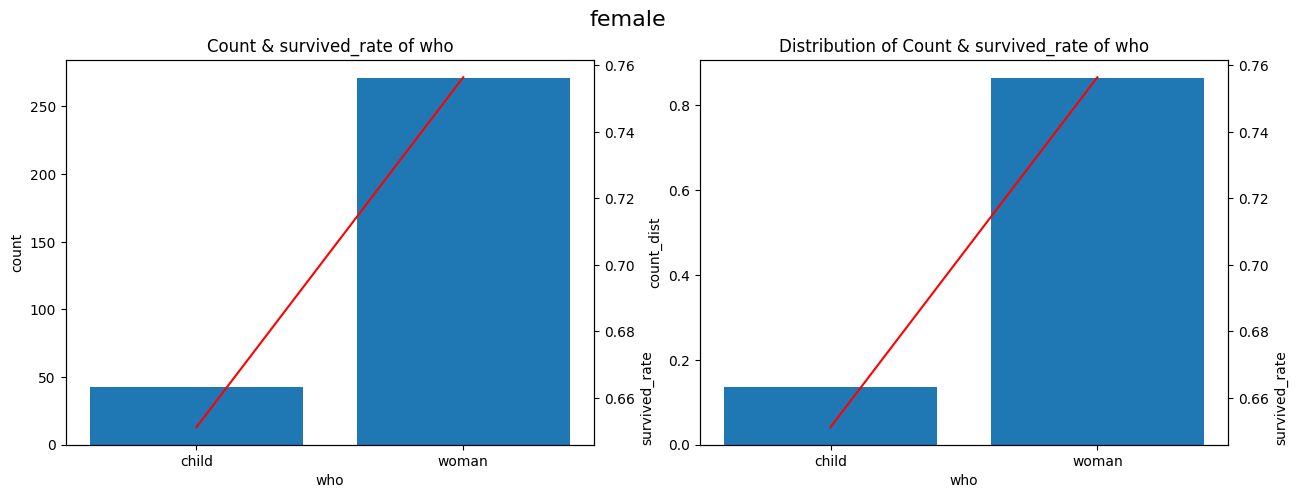

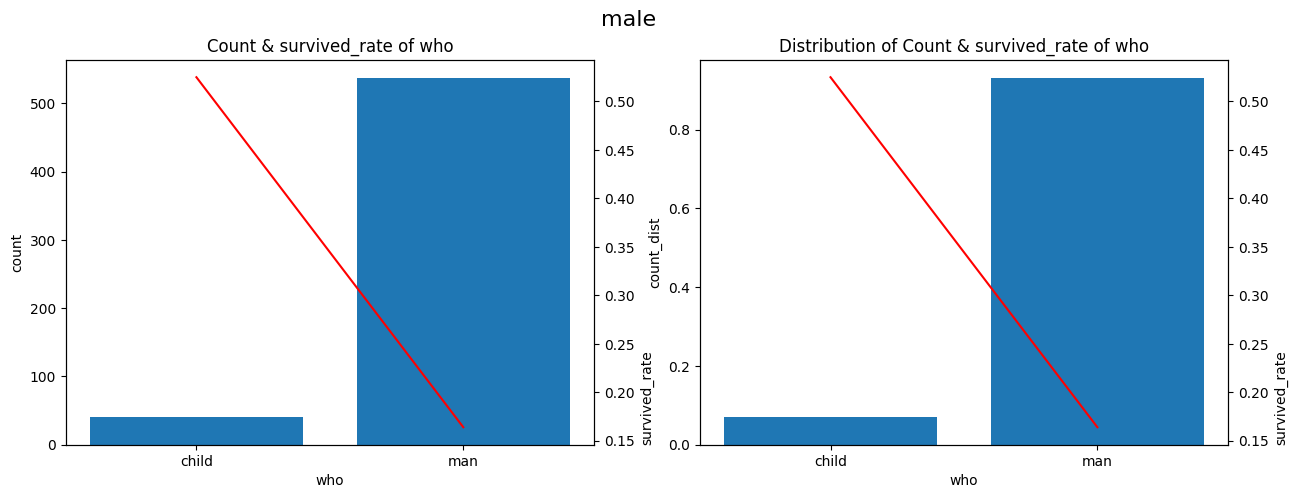

In [150]:
plot_bar_and_line(
    df2,
    col=col,
    target_col=target_col,
    rotation=rotation,
    y_lim=y_lim,
    y_lim2=y_lim2,
    ax2_y_lim=ax2_y_lim
)

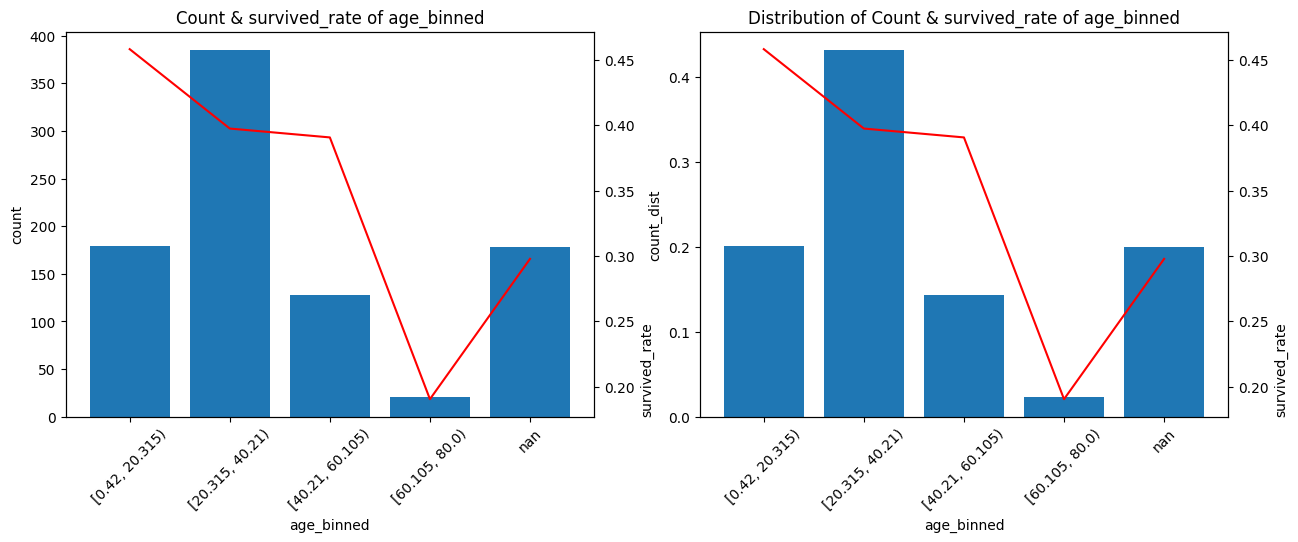

,count,survived,count_dist,survived_dist,survived_rate
age_binned,,,,,
"[0.42, 20.315)",179,82,0.20,0.24,0.46
"[20.315, 40.21)",385,153,0.43,0.45,0.40
"[40.21, 60.105)",128,50,0.14,0.15,0.39
"[60.105, 80.0)",21,4,0.02,0.01,0.19
NaN,178,53,0.20,0.15,0.30


In [151]:
# auto histogram binning
edges = np.histogram_bin_edges(df["age"].dropna(), bins=4)
df["age_binned"] = pd.cut(df["age"], bins=edges, right=False)

_ = calculate_signal(df, target_col="survived", col="age_binned")
plot_bar_and_line(_, col="count",target_col="survived_rate", rotation=45)
_.round(2)

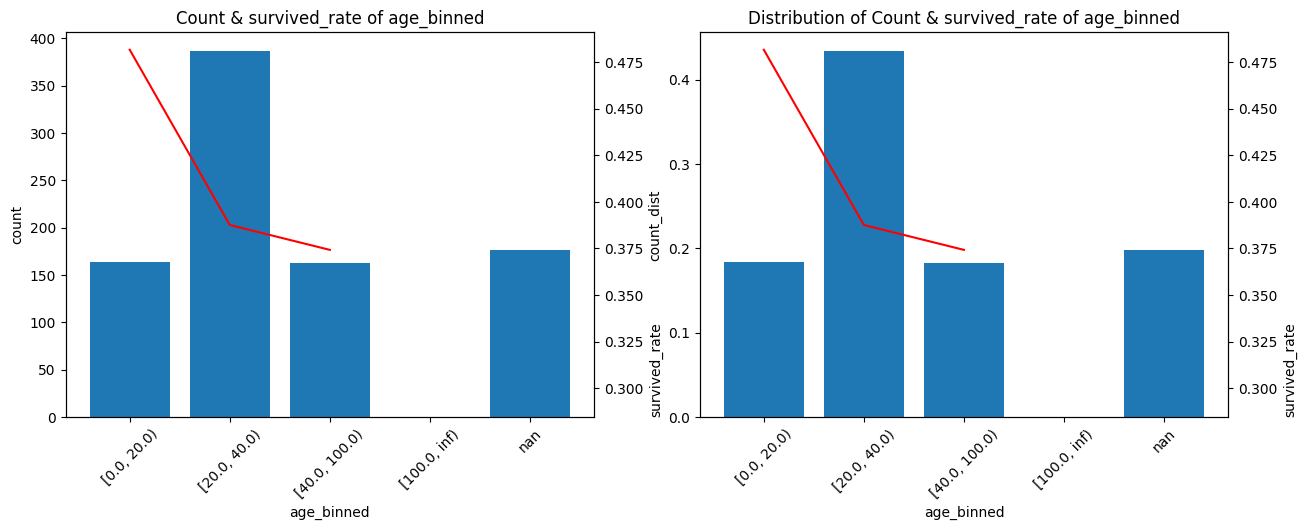

,count,survived,count_dist,survived_dist,survived_rate
age_binned,,,,,
"[-inf, 0.0)",NaN,0,NaN,0.00,NaN
"[0.0, 20.0)",164.0,79,0.18,0.23,0.48
"[20.0, 40.0)",387.0,150,0.43,0.44,0.39
"[40.0, 100.0)",163.0,61,0.18,0.18,0.37
"[100.0, inf)",NaN,0,NaN,0.00,NaN
NaN,177.0,52,0.20,0.15,0.29


In [152]:
# specific binning
edges = [-np.inf, 0, 20, 40, 100, np.inf]
df["age_binned"] = pd.cut(df["age"], bins=edges, right=False)

_ = calculate_signal(df, target_col="survived", col="age_binned")
plot_bar_and_line(_, col="count", target_col="survived_rate", rotation=45)
_.round(2)

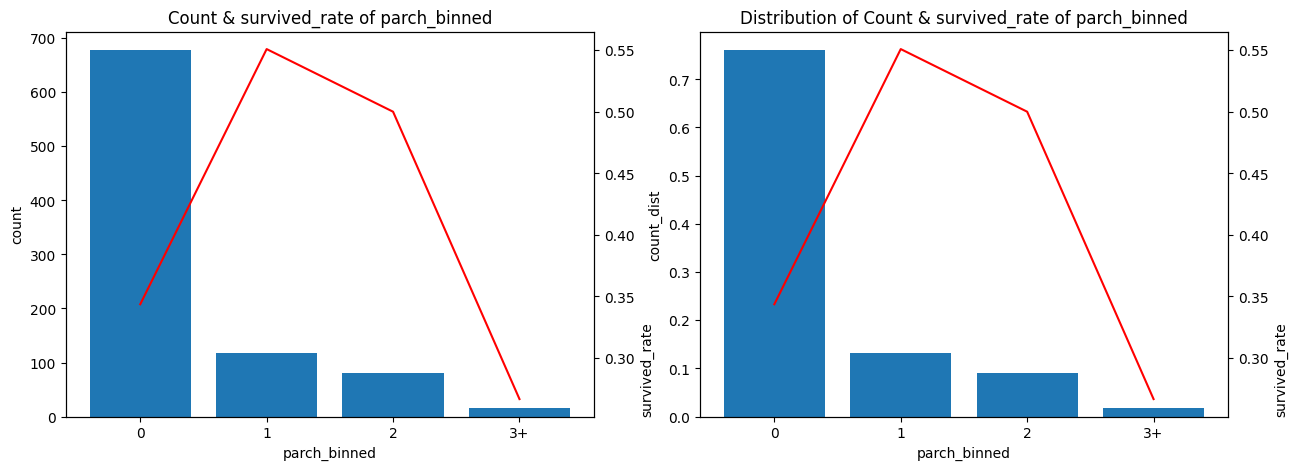

,count,survived,count_dist,survived_dist,survived_rate
parch_binned,,,,,
0,678,233,0.76,0.68,0.34
1,118,65,0.13,0.19,0.55
2,80,40,0.09,0.12,0.50
3+,15,4,0.02,0.01,0.27


In [153]:
idx = df.eval("parch >= 3")
df["parch_binned"] = df["parch"].astype(str)
df.loc[idx, "parch_binned"] = "3+"

_ = calculate_signal(df, target_col="survived", col="parch_binned")
plot_bar_and_line(_, col="count", target_col="survived_rate", rotation=0)
_.round(2)